# Project: "Identification Of Internet Users"

# Part 4. Comparison of algorithms of classification

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import time
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

## 1. Comparison of several algorithms in sessions of 10 sites

In [3]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [4]:
X_sparse_10users.shape

(14061, 4913)

**We divide the sample into 2 parts. On one, we will conduct cross-validation, on the second, we will evaluate the model trained after cross-validation.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**We set the type of cross-validation in advance: 3-fold, with mixing, the parameter random_state = 17 - for reproducibility.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**A helper function for drawing validation curves after running GridSearchCV (or RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**We train the `KNeighborsClassifier` with 100 closest neighbors and show the portion of correct answers for 3x cross-validation:**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier(100, n_jobs=-1)

train_score = list()

for train_indices, test_indices in skf.split(X_train, y_train):
    knn.fit(X_train[train_indices], y_train[train_indices])
    train_score.append(knn.score(X_train[test_indices].todense(), y_train[test_indices]))

print('Cross-validation:', np.around(sum(train_score) / len(train_score), 3))

knn.fit(X_train, y_train)

print('Validation sample:', np.around(accuracy_score(y_valid, knn.predict(X_valid.todense())), 3))

Cross-validation: 0.559
Validation sample: 0.584


**Let's train a random forest (`RandomForestClassifier`) of 100 trees. Let's look at the OOB score and the portion of correct answers on the `(X_valid, y_valid)` sample:**

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
forest = RandomForestClassifier(100, random_state=17, oob_score=True, n_jobs=-1)

forest.fit(X_train, y_train)

print('OOB:', np.around(forest.oob_score_, 3))
print('Accuracy on validation sample:', np.around(forest.score(X_valid.todense(), y_valid), 3))

OOB: 0.717
Accuracy on validation sample: 0.731


**Train Logistic Regression (`LogisticRegression`) with the default parameter` C`. Let's look at the portion of correct answers in cross-validation and in the `(X_valid, y_valid)` sample:**

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [13]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

print('Cross-validation:', np.around(cross_val_score(logit, X_train, y_train, cv=skf).mean(), 3))

logit.fit(X_train, y_train)
print('Validation sample:', np.around(accuracy_score(y_valid, logit.predict(X_valid.todense())), 3))

Cross-validation: 0.761
Validation sample: 0.777


**For logistic regression, there are algorithms for quick selection of the regularization parameter `C` (faster than with` GridSearchCV`).**

**Using `LogisticRegressionCV`, we select the `C` parameter for `LogisticRegression` in the range: 10 values from 1e-4 to 1e2:**

In [14]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, random_state=17, n_jobs=-1, multi_class='multinomial', cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 9.1 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Average values of the portion of correct answers for cross-validation for each of the 10 parameters C:

In [15]:
logit_mean_cv_scores1 = list()
for i in range(len(logit_c_values1)):
    logit_mean_cv_scores1.append((logit_grid_searcher1.scores_[31][:,0+i:1+i].mean(), logit_c_values1[i]))

logit_mean_cv_scores1

[(0.31954964280669934, 0.0001),
 (0.4730739686244774, 0.00046415888336127773),
 (0.552022360820987, 0.002154434690031882),
 (0.6487503500073099, 0.01),
 (0.7143884597943816, 0.046415888336127774),
 (0.751779616813236, 0.21544346900318823),
 (0.7607206619536478, 1.0),
 (0.7585870731459524, 4.641588833612772),
 (0.7499505033910442, 21.54434690031882),
 (0.7399933839326202, 100.0)]

The best value of the portion of correct answers for cross-validation and the corresponding value of C:

In [16]:
print('Accuracy: {0}, C: {1}'.format(*max(logit_mean_cv_scores1)))

Accuracy: 0.7607206619536478, C: 1.0


Graph of the portion of correct answers for cross-validation on `C` (validation curve):

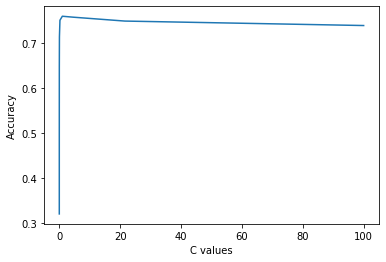

In [17]:
plt.plot(logit_c_values1, [acc[0] for acc in logit_mean_cv_scores1]);
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.show()

**Now the same thing, only the values ​​of the parameter C are sorted in the range: 20 values from 0.1 to 7:**

In [18]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, random_state=17, n_jobs=-1, multi_class='multinomial', cv=skf)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 23.8 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Average values of the portion of correct answers for cross-validation for each of the 10 `C` parameters:

In [19]:
logit_mean_cv_scores2 = list()
for i in range(len(logit_c_values2)):
    # 31 - user id
    logit_mean_cv_scores2.append((logit_grid_searcher2.scores_[31][:,0+i:1+i].mean(), logit_c_values2[i]))

logit_mean_cv_scores2

[(0.7348111695076108, 0.1),
 (0.7592981455187914, 0.4631578947368421),
 (0.7612286681385559, 0.8263157894736842),
 (0.7609237591156771, 1.1894736842105265),
 (0.7613302322066194, 1.5526315789473686),
 (0.7614319201710762, 1.9157894736842107),
 (0.7599077467458613, 2.278947368421053),
 (0.7593997405609533, 2.642105263157895),
 (0.7597045256874391, 3.005263157894737),
 (0.7592982074669878, 3.368421052631579),
 (0.7591966124248257, 3.7315789473684213),
 (0.7585869802236577, 4.094736842105263),
 (0.757774188912264, 4.457894736842105),
 (0.7573678706918127, 4.821052631578947),
 (0.7569614285749685, 5.184210526315789),
 (0.7560469802732164, 5.5473684210526315),
 (0.755437440994343, 5.910526315789474),
 (0.7551326558678572, 6.273684210526316),
 (0.754116612523943, 6.636842105263158),
 (0.7533037282902546, 7.0)]

The best value of the portion of correct answers for cross-validation and the corresponding value of `C`:

In [20]:
print('Accuracy: {0}, C: {1}'.format(*max(logit_mean_cv_scores2)))

Accuracy: 0.7614319201710762, C: 1.9157894736842107


Graph of the portion of correct answers for cross-validation on `C` (validation curve):

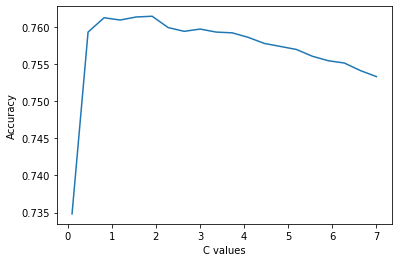

In [21]:
plt.plot(logit_c_values2, [acc[0] for acc in logit_mean_cv_scores2]);
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.show()

The portion of correct answers in the sample `(X_valid, y_valid)` for logistic regression with the best value found for `C`:

In [22]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7802796871296516

Portion of correct responses for `logit_grid_searcher` on cross-validation for the best value of the `C` parameter and on validation sample:

In [23]:
print('Cross-validation:', np.around(cross_val_score(logit_grid_searcher2, X_train, y_train).mean(), 3))
print('Validation sample:', np.around(logit_cv_acc, 3))

Cross-validation: 0.768
Validation sample: 0.78


**Let's train linear SVM (`LinearSVC`) with parameter `C` = 1. Let's look at the portion of correct answers in cross-validation and in the sample `(X_valid, y_valid)`:**

In [24]:
from sklearn.svm import LinearSVC

In [25]:
svm = LinearSVC(C=1, random_state=17)
print('Cross-validation:', cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1).mean())
print('Validation sample:', accuracy_score(y_valid, svm.fit(X_train, y_train).predict(X_valid)))

Cross-validation: 0.7507639141844025
Validation sample: 0.7769613652524295


**Using `GridSearchCV` we select the `C` parameter for SVM first in a wide range: 10 values from 1e-4 to 1e4:**

In [26]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, n_jobs=-1, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 37.5 s


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

The best value of the portion of correct answers for cross-validation and the corresponding value of `C`:

In [27]:
cross_val_score(svm_grid_searcher1.best_estimator_, X_train, y_train, cv=skf).mean()

0.6730328659961394

Graph of the portion of correct answers for cross-validation on `C`:

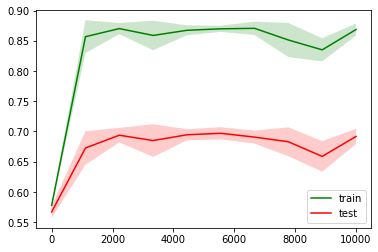

In [28]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Using `GridSearchCV` we select the `C` parameter for SVM in the range (1e-3, 1), 30 values:**

In [29]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, n_jobs=-1, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 52.3 s


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

The best value of the portion of correct answers for cross-validation and the corresponding value of `C`:

In [30]:
cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf).mean()

0.7670206386611259

Graph of the portion of correct answers for cross-validation from C:

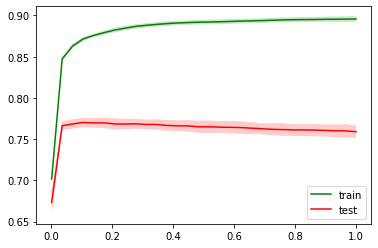

In [31]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

The portion of correct answers in the selection `(X_valid, y_valid)` for `LinearSVC` with the best value found for `C`:

In [32]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

The portion of correct answers for `svm_grid_searcher2` on cross-validation for the best value of the `C` parameter and on validation sample:

In [33]:
print('Cross-validation:', np.around(cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf).mean(), 3))
print('Validation sample:', np.around(svm_cv_acc, 3))

Cross-validation: 0.767
Validation sample: 0.781


## 2. Choice of parameters - session length and window width

**Let's take `LinearSVC`, which showed the best quality in cross-validation in the previous part, and test its performance on 8 more samples for 10 users (with different combinations of parameters *session_length* and *window_size*).**

In [34]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y). 
    Also returns the execution time of the function.
    '''
    time_start = time.time()
    
    with open(path_to_X_pickle, 'rb') as f1, open(path_to_y_pickle, 'rb') as f2:       
        X_sparse = pickle.load(f1)
        y = pickle.load(f2)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size,
                                                          random_state=random_state, stratify=y)
    
    estimator.fit(X_train, y_train)
    
    mean_cv_acc = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    valid_acc = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return np.around((mean_cv_acc, valid_acc), 3), np.around(time.time() - time_start, 3)


For convenience, create copies of the previously created pickle files X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl and y_150users.pkl, adding s10_w10 to their names, which means a session length of 10 and a window width of 10:

In [35]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [36]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = f'X_sparse_10users_s{session_length}_w{window_size}.pkl'
        path_to_y_pkl = f'y_10users_s{session_length}_w{window_size}.pkl'
        print(session_length, window_size, 
             model_assessment(estimator, os.path.join(PATH_TO_DATA, path_to_X_pkl),
        os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3))

15 10 (array([0.824, 0.84 ]), 3.234)
10 10 (array([0.767, 0.781]), 1.842)
15 7 (array([0.85 , 0.854]), 4.406)
10 7 (array([0.798, 0.807]), 2.445)
7 7 (array([0.755, 0.762]), 1.543)
15 5 (array([0.867, 0.875]), 5.789)
10 5 (array([0.818, 0.825]), 3.346)
7 5 (array([0.773, 0.785]), 2.08)
5 5 (array([0.725, 0.736]), 1.391)
Wall time: 26.1 s


In [37]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = f'X_sparse_10users_s{session_length}_w{window_size}.pkl'
    path_to_y_pkl = f'y_10users_s{session_length}_w{window_size}.pkl'
    print(session_length, window_size, model_assessment(estimator, os.path.join(PATH_TO_DATA, path_to_X_pkl),
        os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3))

5 5 (array([0.725, 0.736]), 1.399)
7 7 (array([0.755, 0.762]), 1.571)
10 10 (array([0.767, 0.781]), 1.82)
Wall time: 4.79 s


In [38]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = f'X_sparse_150users_s{session_length}_w{window_size}.pkl'
    path_to_y_pkl = f'y_150users_s{session_length}_w{window_size}.pkl'
    print(session_length, window_size, model_assessment(estimator, os.path.join(PATH_TO_DATA, path_to_X_pkl),
        os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3))

5 5 (array([0.408, 0.422]), 306.1)
7 7 (array([0.437, 0.453]), 266.64)
10 10 (array([0.463, 0.484]), 249.24)
Wall time: 13min 41s


According to a sample of 10 users, with increasing session length and window width, the accuracy of the algorithm increases to a greater and lesser extent, respectively. It is also seen that the accuracy of the prediction of the algorithm fell markedly on a sample of 150 users.

## 3. Identification of a specific user and learning curves

In [39]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [40]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**We will train `LogisticRegressionCV` for one value of the `C` parameter (selected in section 1). We will solve 150 One-to-All problems, so we will specify the argument `multi_class` = 'ovr'**

In [41]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.C_[0]], multi_class='ovr', 
                                         n_jobs=-1, random_state=17, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 4min 35s


LogisticRegressionCV(Cs=[1.9157894736842107], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Average portions of correct responses to cross-validation in the task of identifying each user individually:

In [42]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {0}, CV score: {1}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 6, CV score: 0.9960797806345333
User 13, CV score: 0.9963091551718745
User 15, CV score: 0.995256117523172
User 16, CV score: 0.9918467778090561
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9944011760658097
User 33, CV score: 0.9937651830304547
User 39, CV score: 0.9858830398381867
User 46, CV score: 0.9980398903172666
User 49, CV score: 0.9951935608311699
User 50, CV score: 0.9943281932584739
User 53, CV score: 0.9937130524537862
User 65, CV score: 0.9969451482072295
User 66, CV score: 0.9948077945638234
User 82, CV score: 0.9963717118638766
User 85, CV score: 0.9963717118638766
User 89, CV score: 0.9908771490830232
User 92, CV score: 0.994422028296477
User 100, CV score: 0.9944950111038128
User 102, CV score: 0.9911586541970326
User 103, CV score: 0.9805448687873385
User 105, CV score: 0.9969034437458948
User 106, CV score: 0.9948494990251583
User 118, CV score: 0.9909292796596917
User 119, CV score: 0.9965906602858841
User 120, CV score: 0.994286488797139
User 126

**The results seem impressive, but perhaps we forget about the class imbalance, and a high portion of correct answers can be obtained by constant prediction. Calculate for each user the difference between the portion of correct responses to cross-validation (just calculated using `LogisticRegressionCV`) and the portion of tags in *y_train_150* other than ID 
 this user (this is the portion of correct answers you can get if the classifier always "says" that it is not the user with the number $i$ in the classification problem $i$ - vs-All).**

In [43]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = dict()

for user_id in np.unique(y_train_150):
    print('User_id: {0} {1}'.format(user_id, cv_scores_by_user[user_id] - 
                                    (sum(class_distr) - class_distr[user_id]) / sum(class_distr)))
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (sum(class_distr) - class_distr[user_id]) / sum(class_distr)

User_id: 6 0.011677249173730253
User_id: 13 0.000604714689353858
User_id: 15 0.0008549414573623126
User_id: 16 0.007131462888242401
User_id: 28 0.0024084326420819036
User_id: 31 -5.2130576668418804e-05
User_id: 33 0.0012198554940414663
User_id: 39 0.0019705357980670524
User_id: 46 0.0009174981493643708
User_id: 49 0.0013658211087130834
User_id: 50 0.00017724396067275716
User_id: 53 0.0016681784533899569
User_id: 65 2.0852230667389726e-05
User_id: 66 -5.213057666852983e-05
User_id: 82 2.0852230667389726e-05
User_id: 85 0.00017724396067264614
User_id: 89 0.0008028108806940049
User_id: 92 0.0002710789986758444
User_id: 100 -0.0002502267680085657
User_id: 102 0.0007194019580243349
User_id: 103 0.003544879213453811
User_id: 105 0.0008862198033635638
User_id: 106 0.007631916424259533
User_id: 118 0.0009279242646983432
User_id: 119 0.0006464191506886374
User_id: 120 0.0006255669200211367
User_id: 126 0.001011333187367791
User_id: 127 0.00409746332613925
User_id: 128 0.005098370398173291
User_

In [44]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

127

The portion of users for whom logistic regression on cross-validation gives a better than constant forecast:

In [45]:
np.around(num_better_than_default / len(acc_diff_vs_constant), 3)

0.847

**Further we will build learning curves for a specific user, for example, for the 128th. We compose a new binary vector based on * y_150users *, its values ​​will be 1 or 0 depending on whether the user ID is 128.**

In [46]:
y_binary_128 = [int(id == 128) for id in y_150users]
sum(y_binary_128)

2796

In [47]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**We will calculate the portion of correct responses to cross-validations in the classification task "user128-vs-All" depending on the sample size:**

In [48]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128,
                                              train_sizes=train_sizes, n_jobs=-1, cv=skf)

Wall time: 12.7 s


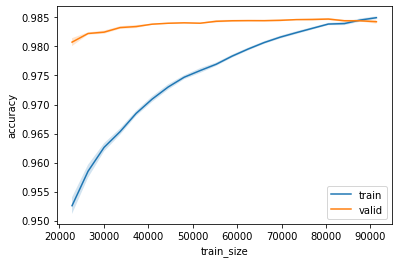

In [49]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

The graph shows that as the size of the training sample increases, the accuracy of the algorithm's predictions on the training sample increases, while the accuracy does not change much on the validation sample.

## Result
* A comparison was made of the work of different algorithms in sessions of 10 sites. For algorithms (LinearSVC and LogisticRegression), hyperparameter C was selected.
* An analysis is made of the influence of parameters - session length and window width on the accuracy of the algorithm predictions.
* The ability of the algorithm to identify a specific user is investigated. Learning curves were also constructed to analyze the effect of the size of the training sample on the accuracy of the predictions of the algorithm on the training sample and validation sample.

In Part 5 (part5_sgd_kaggle.ipynb), using linear models trained using stochastic gradient descent (SGD), we will solve the problem of the Kaggle competition "Catch Me If You Can".